In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.backend import ctc_batch_cost, get_value, ctc_decode
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

D:\Anaconda\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Đọc tệp CSV
train = pd.read_csv('D:/Study/Truc_quan_hoa_data/written_name_v2/written_name_train_v2.csv')
valid = pd.read_csv('D:/Study/Truc_quan_hoa_data/written_name_v2/written_name_validation_v2.csv')


In [3]:
train.value_counts()

FILENAME          IDENTITY 
TRAIN_00001.jpg   BALTHAZAR    1
TRAIN_291526.jpg  CAMPOURCY    1
TRAIN_291506.jpg  BELLO        1
TRAIN_291505.jpg  BOISSIERE    1
TRAIN_291504.jpg  LOUNA        1
                              ..
TRAIN_191201.jpg  CHOMEL       1
TRAIN_191200.jpg  BARDIN       1
TRAIN_19120.jpg   LAURI-ANN    1
TRAIN_191199.jpg  TILLEMAN     1
TRAIN_99999.jpg   DIMITRI      1
Length: 330396, dtype: int64

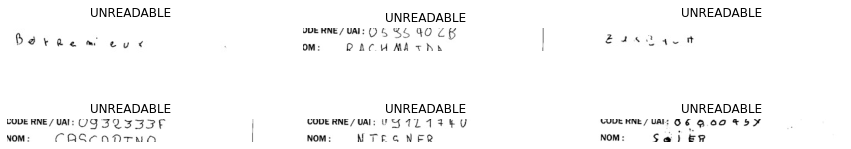

In [4]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'D:/Study/Truc_quan_hoa_data/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [5]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [6]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [7]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

In [8]:
train.value_counts()

FILENAME          IDENTITY       
TRAIN_00001.jpg   BALTHAZAR          1
TRAIN_291526.jpg  CAMPOURCY          1
TRAIN_291506.jpg  BELLO              1
TRAIN_291505.jpg  BOISSIERE          1
TRAIN_291504.jpg  LOUNA              1
                                    ..
TRAIN_191199.jpg  TILLEMAN           1
TRAIN_191198.jpg  CHRISTA JOSETTE    1
TRAIN_191197.jpg  DELFRANCO          1
TRAIN_191196.jpg  JULES              1
TRAIN_99999.jpg   DIMITRI            1
Length: 330294, dtype: int64

In [9]:
def preprocess(img):
    
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [10]:
train_size = 30000
batch_size = 1000
valid_size= 3000

In [11]:
train_x = []
for i in range(0, train_size, batch_size):
    batch_dir = f'D:/Study/Truc_quan_hoa_data/processed_images/batch_{i // batch_size}'
    for j in range(batch_size):
        img_dir = os.path.join(batch_dir, f"processed_img_{i}.jpg")
        image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
        image = image/255.
        train_x.append(image)

In [12]:
valid_x = []

for i in range(valid_size):
    img_dir = 'D:/Study/Truc_quan_hoa_data/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [13]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [14]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [15]:
name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

JEBASTIN 
 [ 9  4  1  0 18 19  8 13]


In [16]:

train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])

In [17]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])    

In [18]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


In [19]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 256, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 256, 64, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max1 (MaxPooling2D)             │ (None, 128, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 128, 32, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 32, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2 (MaxPooling2D)             │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 64, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max3 (MaxPooling2D)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64, 64)         │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm1 (Bidirectional)           │ (None, 64, 512)        │       657,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (Bidirectional)           │ (None, 64, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64, 30)         │        15,390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 64, 30)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,406,878 (9.18 MB)

 Trainable params: 2,406,430 (9.18 MB)

 Non-trainable params: 448 (1.75 KB)

In [20]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return ctc_batch_cost(labels, y_pred, input_length, label_length)

In [21]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [75]:
print(input_data)
print(labels)
print(input_length)
print(label_length)

<KerasTensor shape=(None, 256, 64, 1), dtype=float32, sparse=None, name=input>
<KerasTensor shape=(None, 24), dtype=float32, sparse=None, name=gtruth_labels>
<KerasTensor shape=(None, 1), dtype=int64, sparse=None, name=input_length>
<KerasTensor shape=(None, 1), dtype=int64, sparse=None, name=label_length>


In [22]:
# Giả sử model_final là mô hình bạn đã định nghĩa
optimizer = Adam(learning_rate=0.0001)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

history = model.fit(
    x=[train_x, train_y, train_input_len, train_label_len],
    y=train_output,
    validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
    epochs=60,
    batch_size=128
)

Epoch 1/60

235/235 ━━━━━━━━━━━━━━━━━━━━ 822s 3s/step - loss: 45.3735 - val_loss: 21.0556
Epoch 2/60
235/235 ━━━━━━━━━━━━━━━━━━━━ 850s 4s/step - loss: 20.6125 - val_loss: 20.6122
Epoch 3/60
235/235 ━━━━━━━━━━━━━━━━━━━━ 823s 3s/step - loss: 20.4900 - val_loss: 20.4652
Epoch 4/60
235/235 ━━━━━━━━━━━━━━━━━━━━ 822s 3s/step - loss: 20.4197 - val_loss: 20.3462
Epoch 5/60
235/235 ━━━━━━━━━━━━━━━━━━━━ 815s 3s/step - loss: 20.2998 - val_loss: 20.2276
Epoch 6/60
235/235 ━━━━━━━━━━━━━━━━━━━━ 828s 4s/step - loss: 20.1324 - val_loss: 20.0706
Epoch 7/60
235/235 ━━━━━━━━━━━━━━━━━━━━ 824s 4s/step - loss: 20.0228 - val_loss: 19.9773
Epoch 8/60
235/235 ━━━━━━━━━━━━━━━━━━━━ 818s 3s/step - loss: 19.8349 - val_loss: 19.8918
Epoch 9/60
235/235 ━━━━━━━━━━━━━━━━━━━━ 835s 4s/step - loss: 19.7299 - val_loss: 19.8593
Epoch 10/60
235/235 ━━━━━━━━━━━━━━━━━━━━ 866s 4s/step - loss: 19.7895 - val_loss: 19.8048
Epoch 11/60
235/235 ━━━━━━━━━━━━━━━━━━━━ 893s 4s/step - loss: 19.7112 - val_loss: 19.7761
Epoch 12/60
235/23

ValueError: Layer "functional_1" expects 4 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(1, 256, 64, 1) dtype=float32>]

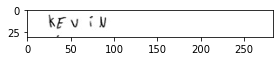

In [87]:
test = pd.read_csv('D:/Study/Truc_quan_hoa_data/written_name_v2/written_name_test_v2.csv')
test.head()

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'D:/Study/Truc_quan_hoa_data/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = get_value(ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)



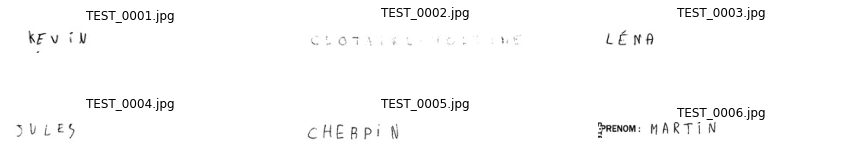

In [83]:
# Đường dẫn tới file csv và thư mục chứa ảnh
test_file = 'D:/Study/Truc_quan_hoa_data/written_name_v2/written_name_test_v2.csv'
img_folder = 'D:/Study/Truc_quan_hoa_data/test_v2/test'

# Đọc file csv
test = pd.read_csv(test_file)

# Kiểm tra và hiển thị ảnh
plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    img_dir = os.path.join(img_folder, test.loc[i, 'FILENAME'])
    
    if not os.path.exists(img_dir):
        print(f"Image does not exist: {img_dir}")
        continue
    
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"Error reading image: {img_dir}")
        continue
    
    plt.imshow(image, cmap='gray')
    plt.title(test.loc[i, 'FILENAME'])
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)
plt.show()

In [85]:
preds = model.predict(valid_x)
decoded = get_value(ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

ValueError: Layer "functional_1" expects 4 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(32, 256, 64, 1) dtype=float32>]

In [33]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

NameError: name 'prediction' is not defined

TypeError: Image data of dtype object cannot be converted to float

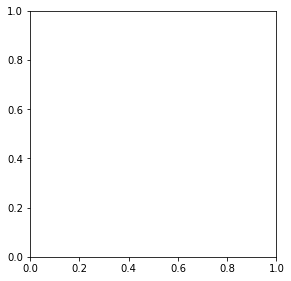

In [35]:
test = pd.read_csv('D:/Study/Truc_quan_hoa_data/written_name_v2/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'D:/Study/Truc_quan_hoa_data/test_v2/test'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = get_value(ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

ValueError: Layer "functional_1" expects 4 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(1, 256, 64, 1) dtype=float32>]

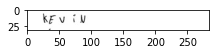

In [37]:
test = pd.read_csv('D:/Study/Truc_quan_hoa_data/written_name_v2/written_name_test_v2.csv')
# Thiết lập kích thước và số lượng hình ảnh cần hiển thị
plt.figure(figsize=(15, 10))
for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    img_dir = 'D:/Study/Truc_quan_hoa_data/test_v2/test/' + test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    
    if image is not None:
        plt.imshow(image, cmap='gray')
        
        # Tiền xử lý ảnh
        image = preprocess(image)
        image = image / 255.0
        
        # Dự đoán
        pred = model.predict(image.reshape(1, 256, 64, 1))
        decoded, _ = tf.keras.backend.ctc_decode(pred, 
                                                 input_length=np.ones(pred.shape[0]) * pred.shape[1],
                                                 greedy=True)
        decoded = tf.keras.backend.get_value(decoded[0])
        
        # Hiển thị nhãn dự đoán
        plt.title(num_to_label(decoded[0]), fontsize=12)
    else:
        plt.title("Image not found", fontsize=12)
    
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)
plt.show()

In [ ]:
model.save('crnn_model.h5')